In [12]:
import numpy as np 
import pandas as pd
import scipy
from scipy import signal
from scipy.io import loadmat
from scipy.interpolate import interp1d

In [13]:
from matplotlib import pyplot as plt

In [14]:
from sklearn.cross_decomposition import PLSRegression, PLSSVD,PLSCanonical

In [15]:
import time

In [74]:
df = pd.read_csv('ECoG.csv')

In [75]:
motion = pd.read_csv('Motion.csv')

In [76]:
def sync_time(motion_data,signal_data):
    start = max(signal_data[0,0],motion_data[0,0])
    end = min(signal_data[-1,0],motion_data[-1,0])
    signal_data = signal_data[:,:][(signal_data[:,0]>=start)]
    signal_data = signal_data[:,:][(signal_data[:,0]<=end)]
    motion_data = motion_data[:,:][motion_data[:,0]>= start]
    motion_data = motion_data[:,:][motion_data[:,0]<= end]
    M = []
    for i in range(1,motion_data.shape[1]):
        interpol = interp1d(motion_data[:,0],motion_data[:,i],kind="cubic")
        x = interpol(signal_data[:,0])
        M.append(x)
    signal = signal_data[::10,1:]
    motion = np.array(M).T[::10,:]
    time = signal_data[::10,0]
    return signal, motion,time

In [78]:
X,Y,time = sync_time(motion.values,df.values)

In [79]:
X = (X - X.mean())/X.std()
Y = (Y - Y.mean())/Y.std()

In [80]:
X.shape

(125838, 32)

# bandpass filter

In [81]:
from scipy.signal import butter, lfilter,freqz,sosfilt

def butter_bandpass(lowcut, highcut, fs, order=7):
    nyq =  fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order,  (low, high), btype='band',analog=False,output='sos')
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=7):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
   # print(a,b)
    y = sosfilt(sos, data)
    return y


fs = 1000
lowcut = 0.2
highcut = 500
for i in range(32):
    X[:,i] = butter_bandpass_filter(X[:,i], lowcut, highcut, fs, order=5)


# Wavelet transform

In [82]:
def wavlet_transform(X, freqs):
    scalo = np.empty((X.shape[0]-110,X.shape[1],freqs.shape[0],11))
    print(X.shape)
    for i in range(X.shape[1]):
        for j in range(110,X.shape[0]):
            scalo[j-110,i,:,:] = signal.cwt(data = X[j-110:j,i],wavelet=signal.morlet,widths = freqs)[:,::10] **2
    return scalo

In [106]:
%%time

scalo = wavlet_transform(X[:100000,:],np.array(range(10,150,15)))

(100000, 32)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


Wall time: 40min 40s


In [108]:
scalo = scalo.reshape((scalo.shape[0],32*10*11))

In [109]:
scalo = (scalo - scalo.mean())/scalo.std()

In [127]:
%%time
model = PLSRegression(n_components=80)
X_train = scalo[:70000,:]
X_test = scalo[70000:,:]
Y_train = Y[110:70110,12:15]
Y_test = Y[70110:100110,12:15]
model.fit(X_train,Y_train)
Y_pred_train =  model.predict(X_train)
Y_pred_test =  model.predict(X_test)


r^2 test (0.5628374456006598, 0.0)
r^2 test (0.010829450448677669, 0.061171960436848805)
r^2 test (0.5660335095980155, 0.0)
r^2 test (0.19257573651025572, 1.3024867879811981e-247)
r^2 test (0.5301575369460235, 0.0)
r^2 test (0.02891938835217922, 5.714324373090705e-07)
Wall time: 16min 16s


In [131]:
for i in range(3):
    print('r^2 train',scipy.stats.pearsonr(Y_pred_train[:,i],Y[110:70110,12+i])[0])
    print('r^2 test',scipy.stats.pearsonr(Y_pred_test[:,i],Y[70110:100000,12+i])[0])

r^2 train 0.5628374456006598
r^2 test 0.010829450448677669
r^2 train 0.5660335095980155
r^2 test 0.19257573651025572
r^2 train 0.5301575369460235
r^2 test 0.02891938835217922


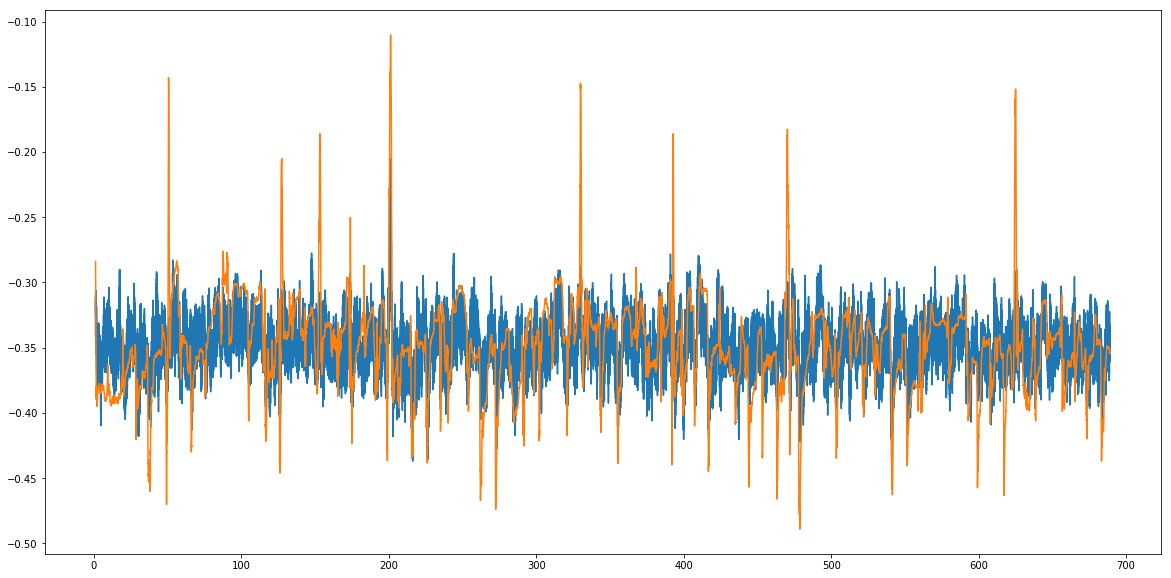

In [129]:
plt.figure(figsize=(20,10))
plt.plot(time[110:70110],Y_pred_train[:70000,1])
plt.plot(time[110:70110],Y[110:70110,13])

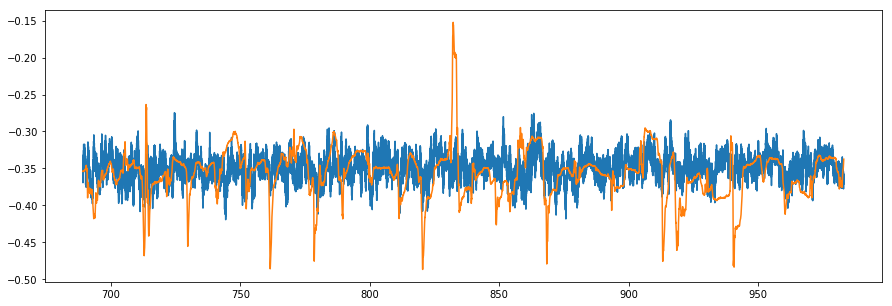

In [124]:
plt.figure(figsize=(15,5))
plt.plot(time[70110:100000],Y_pred_test[:,1])
plt.plot(time[70110:100000],Y[70110:100000,13])

## Данные Мотренко

In [252]:
X_mat = loadmat('ECoG_X_train.mat')
Y_mat = loadmat('ECoG_Y_train.mat')

In [267]:
X1 = X_mat["X_train"].reshape((X_mat["X_train"].shape[0],X_mat["X_train"].shape[1]*X_mat["X_train"].shape[2]))
Y1 = Y_mat["Y_train"]

In [271]:
X1.shape

(12801, 864)

In [275]:
model1 = PLSRegression(n_components=100)
model1.fit(X1,Y1)

PLSRegression(copy=True, max_iter=500, n_components=100, scale=True,
       tol=1e-06)

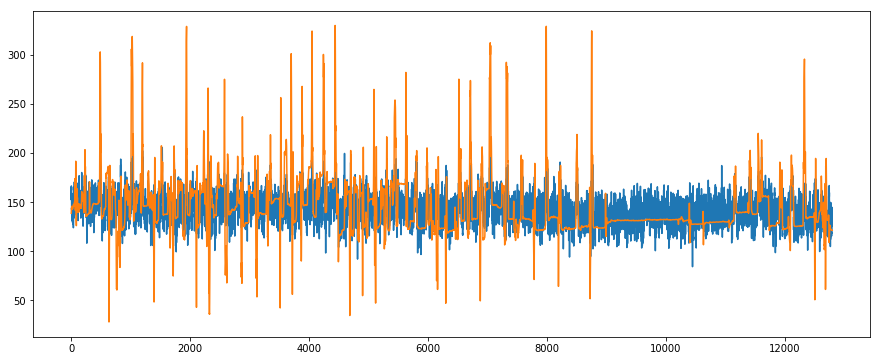

In [279]:
Y_pred1 = model1.predict(X1)
plt.figure(figsize=(15,6))
plt.plot(range(Y_pred1.shape[0]), Y_pred1[:,0])
plt.plot(range(Y_pred1.shape[0]), Y1[:,0])


In [116]:
import pywt

In [7]:
class ECoG(object):
    def __init__(self,signal_data,motion_data):
        start = max(signal_data[0,0],motion_data[0,0])
        end = min(signal_data[-1,0],motion_data[-1,0])
        signal_data = signal_data[:,:][(signal_data[:,0]>=start)]
        signal_data = signal_data[:,:][(signal_data[:,0]<=end)]
        motion_data = motion_data[:,:][motion_data[:,0]>= start]
        motion_data = motion_data[:,:][motion_data[:,0]<= end]
        M = []
        for i in range(1,motion_data.shape[1]):
            interpol = interp1d(motion_data[:,0],motion_data[:,i],kind="cubic")
            x = interpol(signal_data[:,0])
            M.append(x)
        self.signal = signal_data[::10,1:]
        self.motion = np.array(M).T[::10,:]
        self.time = signal_data[::10,0]
    def plot_signal(self,start,end,electrodes = 'all'):
        if electrodes == 'all':
            for el in range(self.signal.shape[1]):
                plt.figure(figsize=(14,5))
                plt.plot(self.time[start:end],self.signal[start:end,el])
                plt.title("Electrode "+str(el))
                plt.xlabel("time")
                plt.ylabel("voltage")
                plt.show()
            return
        for el in electrodes:
            plt.figure(figsize=(14,5))
            plt.plot(self.time[start:end],self.signal[start:end,el])
            plt.title("Electrode"+str(el))
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.show()
        return
    def spectrum(self,start,end,freq,electrodes = 'all'):
        if electrodes == 'all':
            X = np.empty((self.signal.shape[1],end-start-110,len(freq),11))
            for el in range(self.signal.shape[1]):
                S = self.signal[start:end,el]
                X[el,:,:,:] = np.array([signal.cwt(S[i-110:i],wavelet= signal.morlet ,widths= freq) for i in range(start + 110,end-start)])[:,:,::10]
            return X
        for el in electrodes:
            S = self.signal[start:end,el]
            M = np.array([signal.cwt(S[i-110:i],wavelet= signal.morlet ,widths= freq) for i in range(end - start + 110)])
            return M

    def plot_spectrum(self,start ,end,freq,electrodes = 'all'):
        if electrodes == 'all':
            for el in range(self.signal.shape[1]):
                S = self.signal[start:end,el]
                X = signal.cwt(data=S,wavelet= signal.morlet ,widths= freq)
                plt.figure(figsize=(15,14))
                plt.imshow(X,cmap='hot')
                plt.title("Electrode "+ str(el))
                plt.show()
            return
        for el in electrodes:
            S = self.signal[start:end,el]
            X = signal.cwt(data=S,wavelet= signal.morlet ,widths= freq)
            plt.figure(figsize=(15,14))
            plt.imshow(X,cmap='hot')
            plt.title("Electrode "+ str(el))
            plt.show()
        return

In [8]:
sig1 = ECoG(df.values[:,:],motion.values[:,:])

In [9]:
%%time
Spec = sig1.spectrum(0,10000,range(10,110,10)) #извлечение признаков

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


Wall time: 3min 36s


In [21]:
Spec

(32, 9890, 10, 11)

In [23]:
Spec =Spec[:,:,1:-2,:]

In [24]:
X = Spec[0].reshape((Spec.shape[1],Spec.shape[2]*Spec.shape[3])) #вытягивание в вектор
for i in range(1,Spec.shape[0]):
    X = np.hstack((X,Spec[i].reshape((Spec.shape[1],Spec.shape[2]*Spec.shape[3]))))

In [11]:
Y = sig1.motion[110:10000,15:18]

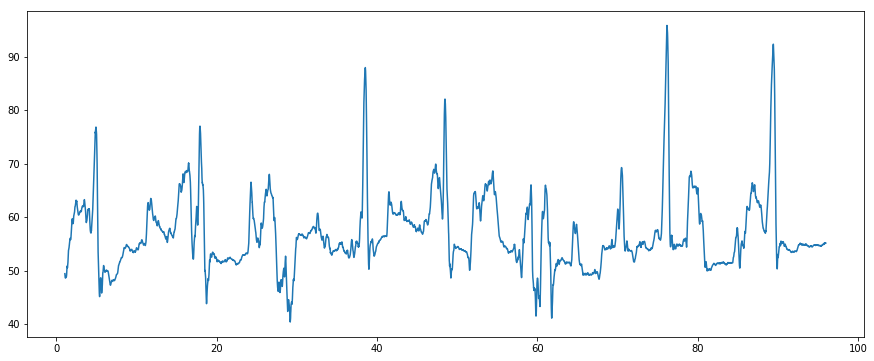

In [14]:
plt.figure(figsize=(15,6))
plt.plot(sig1.time[110:10000,],Y[:,0]) 

In [15]:
X = (X - X.mean())/X.std()
Y = (Y - Y.mean())/Y.std()

In [75]:
X_train = X[60:7560,:]
Y_train = Y[:7500,:]

In [212]:
X1 = X[::10,:]
Y1 = Y[::10,:]

In [105]:
from sklearn.linear_model import Lasso

In [113]:
m = Lasso(normalize= True)
m.fit(X_train,Y_train[:,0])
Y_p = model.predict(X_train)

In [110]:
m.coef_

array([ 0., -0.,  0., ..., -0.,  0.,  0.])

In [76]:
%%time
model = PLSRegression(n_components= 30)
model.fit(X_train[:10000],Y_train[:10000])
Y_pred = model.predict(X_train[:10000])

Wall time: 19.5 s


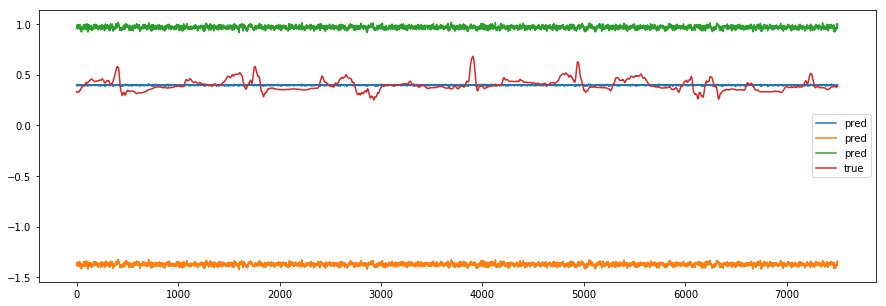

In [114]:
plt.figure(figsize= (15,5))
plt.plot(range(0,7500),Y_p,label = "pred")
plt.plot(range(7500),Y_train[:10000,0],label = "true")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (75000,) and (7500,)

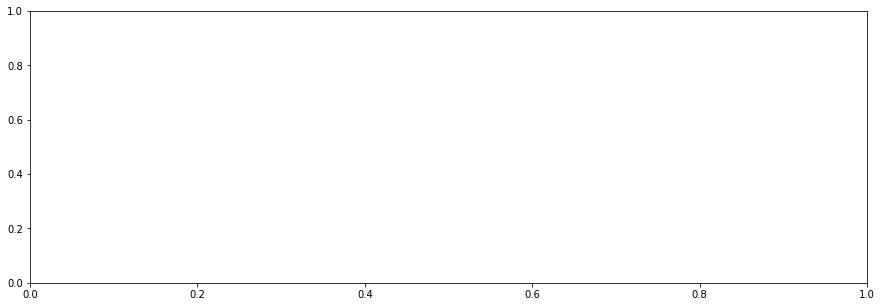

In [65]:

for i in range(3):
    plt.figure(figsize= (15,5))
    plt.plot(sig1.time[110:75110],Y_pred[:,i],label = "pred")
    plt.plot(sig1.time[110:75110],Y_train[:,i],label = "true")
    plt.legend()
X_test = X[75000:,:]
Y_test = Y[75000:,:]
Y_pred_test = model.predict(X_test)
for i in range(3):
    plt.figure(figsize= (15,5))
    plt.plot(sig1.time[75110:100000],Y_pred_test[:,i],label = "pred")
    plt.plot(sig1.time[76100:100000],Y_test[:,i],label = "true")
    plt.legend()

In [325]:
Spec[2,3,:,:]

array([[ 20.67469998,  10.17953941,  -8.69101303,  -1.82527981,
         18.92385609,   7.71079329,  -8.76939618, -17.24727102,
        -11.99091435,   2.15215295,  -0.56068282],
       [ 20.67469998,  10.17953941,  -8.69101303,  -1.82527981,
         18.92385609,   7.71079329,  -8.76939618, -17.24727102,
        -11.99091435,   2.15215295,  -0.56068282],
       [ 20.67469998,  10.17953941,  -8.69101303,  -1.82527981,
         18.92385609,   7.71079329,  -8.76939618, -17.24727102,
        -11.99091435,   2.15215295,  -0.56068282],
       [ 20.67469998,  10.17953941,  -8.69101303,  -1.82527981,
         18.92385609,   7.71079329,  -8.76939618, -17.24727102,
        -11.99091435,   2.15215295,  -0.56068282],
       [ 20.67469998,  10.17953941,  -8.69101303,  -1.82527981,
         18.92385609,   7.71079329,  -8.76939618, -17.24727102,
        -11.99091435,   2.15215295,  -0.56068282],
       [ 20.67469998,  10.17953941,  -8.69101303,  -1.82527981,
         18.92385609,   7.71079329,  -8.7

In [301]:
s1 = sig1.signal[0:1000,2]
A = np.array([signal.cwt(s1[i-110:i],wavelet = signal.morlet ,widths= [10,20,30,40]) for i in range(110,113)])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


In [322]:
A = 0

In [323]:
s1 = 0